# Capstone Project 2

## Predict who will win an NFL bet

Data Source:  
    
    Main/Historical https://datasetsearch.research.google.com/search?query=NFL%20scores%20and%20betting%20data&docid=42gvYWceSRPsddH5AAAAAA%3D%3D

    Current Week Odds:     https://www.vegasinsider.com/nfl/odds/las-vegas     
    Current Week Odds:     https://www.teamrankings.com/nfl-odds-week-#  (where # is week number)
    Current Year Results:  https://www.teamrankings.com/nfl-odds-week-#  (where # is week number)
    

In [72]:
# packages
import os
import pandas as pd
import numpy  as np
import csv
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=DeprecationWarning)
#    import sklearn
# required machine learning packages
from sklearn import model_selection
from sklearn import linear_model, tree, discriminant_analysis, naive_bayes, ensemble, gaussian_process
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

#from sklearn.feature_selection import RFE
#from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import xgboost as xgb

In [2]:
datapath = "input/"

teams      = pd.read_csv(datapath + "nfl_teams.csv")
scores     = pd.read_csv(datapath + "nfl_scores.csv")
scoreswork = pd.read_csv(datapath + "nfl_scores_2020work.csv", encoding='latin-1', index_col=False, header=None, 
                         names=['col1','col2','col3','col4','col5'])
stadiums   = pd.read_csv(datapath + "nfl_stadiums.csv", encoding='latin-1')

In [3]:
# Drop unneeded columns
scores.drop(columns=['stadium', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'weather_detail'],inplace=True)
teams.drop(columns=['team_name_short', 'team_id_pfr','team_conference','team_division','team_conference_pre2002','team_division_pre2002'],inplace=True)

# Only use data since 2015
scores = scores[scores['schedule_season'] >= 2015]

In [4]:
scoreswork.info()
scoreswork.head(14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   col1    1143 non-null   object
 1   col2    768 non-null    object
 2   col3    768 non-null    object
 3   col4    768 non-null    object
 4   col5    768 non-null    object
dtypes: object(5)
memory usage: 60.0+ KB


,col1,col2,col3,col4,col5
0,2020 NFL Week 1 Odds,NaN,NaN,NaN,NaN
1,Latest OddsOdds History,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,Division:,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,Team: ...,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,"Thursday, September 10th, 2020",NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [5]:
# Assign team_id
def f_team_id(team_city):
    if team_city == 'Arizona':
        team_id = 'ARI'
    elif team_city == 'Atlanta':
        team_id = 'ATL'
    elif team_city == 'Baltimore':
        team_id = 'BAL'
    elif team_city == 'Buffalo':
        team_id = 'BUF'
    elif team_city == 'Carolina':
        team_id = 'CAR'
    elif team_city == 'Chicago':
        team_id = 'CHI'
    elif team_city == 'Cincinnati':
        team_id = 'CIN'
    elif team_city == 'Cleveland':
        team_id = 'CLE'
    elif team_city == 'Dallas':
        team_id = 'DAL'
    elif team_city == 'Denver':
        team_id = 'DEN'
    elif team_city == 'Detroit':
        team_id = 'DET'
    elif team_city == 'Green Bay':
        team_id = 'GB'
    elif team_city == 'Houston':
        team_id = 'HOU'
    elif team_city == 'Indianapolis':
        team_id = 'IND'
    elif team_city == 'Jacksonville':
        team_id = 'JAX'
    elif team_city == 'Kansas City':
        team_id = 'KC'
    elif team_city == 'LA Chargers':
        team_id = 'LAC'
    elif team_city == 'LA Rams':
        team_id = 'LAR'
    elif team_city == 'Las Vegas':
        team_id = 'LVR'
    elif team_city == 'Miami':
        team_id = 'MIA'
    elif team_city == 'Minnesota':
        team_id = 'MIN'
    elif team_city == 'New England':
        team_id = 'NE'
    elif team_city == 'New Orleans':
        team_id = 'NO'
    elif team_city == 'NY Giants':
        team_id = 'NYG'
    elif team_city == 'NY Jets':
        team_id = 'NYJ'
    elif team_city == 'Philadelphia':
        team_id = 'PHI'
    elif team_city == 'Pittsburgh':
        team_id = 'PIT'
    elif team_city == 'San Francisco':
        team_id = 'SF'
    elif team_city == 'Seattle':
        team_id = 'SEA'
    elif team_city == 'St. Louis':
        team_id = 'SCA'
    elif team_city == 'Tampa Bay':
        team_id = 'TB'
    elif team_city == 'Tennessee':
        team_id = 'TEN'
    elif team_city == 'Washington':
        team_id = 'WAS'
    else:
        team_id = 'ZZZ'
    
    return team_id

In [6]:
# Assign team_name
def f_team_name(team_city):
    if team_city == 'Arizona':
        team_name = 'Arizona Cardinals'
    elif team_city == 'Atlanta':
        team_name = 'Atlanta Falcons'
    elif team_city == 'Baltimore':
        team_name = 'Baltimore Ravens'
    elif team_city == 'Buffalo':
        team_name = 'Buffalo Bills'
    elif team_city == 'Carolina':
        team_name = 'Carolina Panthers'
    elif team_city == 'Chicago':
        team_name = 'Chicago Bears'
    elif team_city == 'Cincinnati':
        team_name = 'Cincinatti Bengals'
    elif team_city == 'Cleveland':
        team_name = 'Cleveland Browns'
    elif team_city == 'Dallas':
        team_name = 'Dallas Cowboys'
    elif team_city == 'Denver':
        team_name = 'Denver Broncos'
    elif team_city == 'Detroit':
        team_name = 'Detroit Lions'
    elif team_city == 'Green Bay':
        team_name = 'Green Bay Packers'
    elif team_city == 'Houston':
        team_name = 'Houston Texans'
    elif team_city == 'Indianapolis':
        team_name = 'Indianapolis Colts'
    elif team_city == 'Jacksonville':
        team_name = 'Jacksonville Jaguars'
    elif team_city == 'Kansas City':
        team_name = 'Kansas City Chiefs'
    elif team_city == 'LA Chargers':
        team_name = 'LA Chargers'
    elif team_city == 'LA Rams':
        team_name = 'Los Angeles Rams'
    elif team_city == 'Las Vegas':
        team_name = 'Las Vegas Raiders'
    elif team_city == 'Miami':
        team_name = 'Miami Dolphins'
    elif team_city == 'Minnesota':
        team_name = 'Minnesota Vikings'
    elif team_city == 'New England':
        team_name = 'New England Patriots'
    elif team_city == 'New Orleans':
        team_name = 'New Orleans Saints'
    elif team_city == 'NY Giants':
        team_name = 'NY Giants'
    elif team_city == 'NY Jets':
        team_name = 'NY Jets'
    elif team_city == 'Philadelphia':
        team_name = 'Philadelphia Eagles'
    elif team_city == 'Pittsburgh':
        team_name = 'Pittsburh Steelers'
    elif team_city == 'San Francisco':
        team_name = 'San Francisco 49ers'
    elif team_city == 'Seattle':
        team_name = 'Seattle Seahawks'
    elif team_city == 'Tampa Bay':
        team_name = 'Tampa Bay Buccaneers'
    elif team_city == 'Tennessee':
        team_name = 'Tennesee Titans'
    elif team_city == 'Washington':
        team_name = 'Washington Football Team'
    else:
        team_name = 'ZZZZZZZZZZZZZZZZ'
    
    print('team_city',team_city,'team_name',team_name)
    return team_name

In [7]:
# Convert current year information
scoreswork['col1'] = scoreswork['col1'].astype(str)
team_away = 'x'
team_home = 'x'
schedule_playoff = 'FALSE'

nfl_scores_current = pd.DataFrame(columns=
                     ['schedule_date', 
                      'schedule_season', 
                      'schedule_week', 
                      'schedule_playoff',
                      'team_home',
                      'score_home',
                      'score_away',
                      'team_away',
                      'team_favorite_id',
                      'spread_favorite',
                      'over_under_line'])

for label, row in scoreswork.iterrows():
    # Find NFL Week
    if row['col1'].find('NFL Week') > -1:
        schedule_season = row['col1'][0:4]
        schedule_week = row['col1'][14:16]
    
    # Convert "weekday, month day, year" to date  
    elif row['col1'].find('st, 2020') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %dst, %Y").date()
    elif row['col1'].find('nd, 2020') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %dnd, %Y").date()
    elif row['col1'].find('rd, 2020') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %drd, %Y").date()
    elif row['col1'].find('th, 2020') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %dth, %Y").date()
    elif row['col1'].find(', 2020')   > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %d, %Y").date()
 
    elif row['col1'].find('st, 2021') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %dst, %Y").date()
    elif row['col1'].find('nd, 2021') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %dnd, %Y").date()
    elif row['col1'].find('rd, 2021') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %drd, %Y").date()
    elif row['col1'].find('th, 2021') > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %dth, %Y").date()
    elif row['col1'].find(', 2021')   > -1:
        schedule_date = datetime.strptime(row['col1'], "%A, %B %d, %Y").date()
        
    elif row['col1'].find('EST') > -1:
        team_away = ''
        team_home = ''
        spread_favorite = 0
        team_favorite_id = ''
        
    elif team_away == '':
        team_away=row['col1']
        score_away=row['col2']
        if float(row['col3']) < 0:
            spread_favorite = float(row['col3'])
            team_favorite_id = f_team_id(team_away)
        if row['col4'] not in ['over','under','push']:
            over_under_line = float(row['col4'])
            
    elif team_home == '':
        team_home=row['col1']
        score_home=row['col2']
        if float(row['col3']) < 0:
            spread_favorite = float(row['col3'])
            team_favorite_id = f_team_id(team_home)
        if row['col4'] not in ['over','under','push']:
            over_under_line = float(row['col4'])
        team_away        = f_team_name(team_away)
        team_home        = f_team_name(team_home)
        nfl_scores_data = [schedule_date, 
                      schedule_season, 
                      schedule_week, 
                      schedule_playoff,
                      team_home,
                      score_home,
                      score_away,
                      team_away,
                      team_favorite_id,
                      spread_favorite,
                      over_under_line]
        nfl_scores_current = pd.concat([pd.DataFrame([nfl_scores_data], columns=nfl_scores_current.columns), nfl_scores_current])

nfl_scores_current.reset_index()
nfl_scores_current.head()

team_city Houston team_name Houston Texans
team_city Kansas City team_name Kansas City Chiefs
team_city Chicago team_name Chicago Bears
team_city Detroit team_name Detroit Lions
team_city Cleveland team_name Cleveland Browns
team_city Baltimore team_name Baltimore Ravens
team_city Philadelphia team_name Philadelphia Eagles
team_city Washington team_name Washington Football Team
team_city Green Bay team_name Green Bay Packers
team_city Minnesota team_name Minnesota Vikings
team_city Indianapolis team_name Indianapolis Colts
team_city Jacksonville team_name Jacksonville Jaguars
team_city Las Vegas team_name Las Vegas Raiders
team_city Carolina team_name Carolina Panthers
team_city Miami team_name Miami Dolphins
team_city New England team_name New England Patriots
team_city NY Jets team_name NY Jets
team_city Buffalo team_name Buffalo Bills
team_city Seattle team_name Seattle Seahawks
team_city Atlanta team_name Atlanta Falcons
team_city LA Chargers team_name LA Chargers
team_city Cincinn

team_city Las Vegas team_name Las Vegas Raiders
team_city Kansas City team_name Kansas City Chiefs
team_city Denver team_name Denver Broncos
team_city San Francisco team_name San Francisco 49ers
team_city New England team_name New England Patriots
team_city Jacksonville team_name Jacksonville Jaguars
team_city LA Chargers team_name LA Chargers
team_city Seattle team_name Seattle Seahawks
team_city Arizona team_name Arizona Cardinals
team_city Chicago team_name Chicago Bears
team_city LA Rams team_name Los Angeles Rams
team_city Atlanta team_name Atlanta Falcons
team_city Carolina team_name Carolina Panthers
team_city NY Jets team_name NY Jets
team_city Kansas City team_name Kansas City Chiefs
team_city Las Vegas team_name Las Vegas Raiders
team_city Cleveland team_name Cleveland Browns
team_city Pittsburgh team_name Pittsburh Steelers
team_city Baltimore team_name Baltimore Ravens
team_city Indianapolis team_name Indianapolis Colts
team_city Detroit team_name Detroit Lions
team_city Ne

team_city Dallas team_name Dallas Cowboys
team_city Baltimore team_name Baltimore Ravens
team_city New England team_name New England Patriots
team_city LA Rams team_name Los Angeles Rams
team_city Dallas team_name Dallas Cowboys
team_city Cincinnati team_name Cincinatti Bengals
team_city Minnesota team_name Minnesota Vikings
team_city Tampa Bay team_name Tampa Bay Buccaneers
team_city Houston team_name Houston Texans
team_city Chicago team_name Chicago Bears
team_city Arizona team_name Arizona Cardinals
team_city NY Giants team_name NY Giants
team_city Denver team_name Denver Broncos
team_city Carolina team_name Carolina Panthers
team_city Tennessee team_name Tennesee Titans
team_city Jacksonville team_name Jacksonville Jaguars
team_city Kansas City team_name Kansas City Chiefs
team_city Miami team_name Miami Dolphins
team_city Indianapolis team_name Indianapolis Colts
team_city Las Vegas team_name Las Vegas Raiders
team_city NY Jets team_name NY Jets
team_city Seattle team_name Seattl

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line
0,2021-01-03,2020,17,FALSE,Philadelphia Eagles,14,20,Washington Football Team,WAS,-6.5,44.0
0,2021-01-03,2020,17,FALSE,San Francisco 49ers,23,26,Seattle Seahawks,SEA,-7.0,44.5
0,2021-01-03,2020,17,FALSE,Houston Texans,38,41,Tennesee Titans,TEN,-7.0,55.5
0,2021-01-03,2020,17,FALSE,Kansas City Chiefs,21,38,LA Chargers,LAC,-7.0,43.0
0,2021-01-03,2020,17,FALSE,Denver Broncos,31,32,Las Vegas Raiders,LVR,-2.5,50.5


In [8]:
teams.info()
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   team_name  43 non-null     object
 1   team_id    43 non-null     object
dtypes: object(2)
memory usage: 816.0+ bytes


,team_name,team_id
0,Arizona Cardinals,ARI
1,Atlanta Falcons,ATL
2,Baltimore Ravens,BAL
3,Boston Patriots,BOS
4,Buffalo Bills,BUF


In [9]:
#scores['schedule_date'].astype('date').dtypes
scores['schedule_date']   = pd.to_datetime(scores['schedule_date'], format='%m/%d/%Y')
scores['over_under_line'] = pd.to_numeric(scores['over_under_line'])
scores.info()
scores.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1335 entries, 11343 to 12677
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   schedule_date     1335 non-null   datetime64[ns]
 1   schedule_season   1335 non-null   int64         
 2   schedule_week     1335 non-null   object        
 3   schedule_playoff  1335 non-null   bool          
 4   team_home         1335 non-null   object        
 5   score_home        1335 non-null   int64         
 6   score_away        1335 non-null   int64         
 7   team_away         1335 non-null   object        
 8   team_favorite_id  1335 non-null   object        
 9   spread_favorite   1335 non-null   float64       
 10  over_under_line   1335 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 116.0+ KB


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line
11343,2015-09-10,2015,1,False,New England Patriots,28,21,Pittsburgh Steelers,NE,-7.0,51.0
11344,2015-09-13,2015,1,False,Arizona Cardinals,31,19,New Orleans Saints,ARI,-2.5,48.5
11345,2015-09-13,2015,1,False,Buffalo Bills,27,14,Indianapolis Colts,IND,-1.0,44.5
11346,2015-09-13,2015,1,False,Chicago Bears,23,31,Green Bay Packers,GB,-6.5,48.5
11347,2015-09-13,2015,1,False,Dallas Cowboys,27,26,New York Giants,DAL,-7.0,52.5


In [10]:
scores_teams = pd.merge(scores,teams,left_on='team_favorite_id',right_on='team_id',how='left')
scores_teams.info()
scores_teams.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1335 entries, 0 to 1334
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   schedule_date     1335 non-null   datetime64[ns]
 1   schedule_season   1335 non-null   int64         
 2   schedule_week     1335 non-null   object        
 3   schedule_playoff  1335 non-null   bool          
 4   team_home         1335 non-null   object        
 5   score_home        1335 non-null   int64         
 6   score_away        1335 non-null   int64         
 7   team_away         1335 non-null   object        
 8   team_favorite_id  1335 non-null   object        
 9   spread_favorite   1335 non-null   float64       
 10  over_under_line   1335 non-null   float64       
 11  team_name         1328 non-null   object        
 12  team_id           1328 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 1

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,team_name,team_id
1325,2020-01-04,2019,Wildcard,True,New England Patriots,13,20,Tennessee Titans,NE,-4.5,45.0,New England Patriots,NE
1326,2020-01-05,2019,Wildcard,True,New Orleans Saints,20,26,Minnesota Vikings,NO,-7.5,49.5,New Orleans Saints,NO
1327,2020-01-05,2019,Wildcard,True,Philadelphia Eagles,9,17,Seattle Seahawks,PHI,-1.0,44.5,Philadelphia Eagles,PHI
1328,2020-01-11,2019,Division,True,Baltimore Ravens,12,28,Tennessee Titans,BAL,-10.0,47.5,Baltimore Ravens,BAL
1329,2020-01-11,2019,Division,True,San Francisco 49ers,27,10,Minnesota Vikings,SF,-7.0,44.5,San Francisco 49ers,SF
1330,2020-01-12,2019,Division,True,Green Bay Packers,28,23,Seattle Seahawks,GB,-4.5,45.5,Green Bay Packers,GB
1331,2020-01-12,2019,Division,True,Kansas City Chiefs,51,31,Houston Texans,KC,-10.0,50.5,Kansas City Chiefs,KC
1332,2020-01-19,2019,Conference,True,Kansas City Chiefs,35,24,Tennessee Titans,KC,-7.0,51.0,Kansas City Chiefs,KC
1333,2020-01-19,2019,Conference,True,San Francisco 49ers,37,20,Green Bay Packers,SF,-8.0,46.5,San Francisco 49ers,SF
1334,2020-02-02,2019,Superbowl,True,Kansas City Chiefs,31,20,San Francisco 49ers,KC,-1.5,53.0,Kansas City Chiefs,KC


In [11]:
# Find where team_favorite_id is not found
scores_teams[scores_teams['team_id'].isnull()]

# team_favorite_id is not found when it is 'PICK' and spread_favorite is 0.0

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,team_name,team_id
37,2015-09-27,2015,3,False,Dallas Cowboys,28,39,Atlanta Falcons,PICK,0.0,43.5,NaN,NaN
116,2015-11-01,2015,8,False,Pittsburgh Steelers,10,16,Cincinnati Bengals,PICK,0.0,49.5,NaN,NaN
155,2015-11-22,2015,11,False,Minnesota Vikings,13,30,Green Bay Packers,PICK,0.0,45.0,NaN,NaN
189,2015-12-06,2015,13,False,Tampa Bay Buccaneers,23,19,Atlanta Falcons,PICK,0.0,46.5,NaN,NaN
283,2016-09-15,2016,2,False,Buffalo Bills,31,37,New York Jets,PICK,0.0,40.5,NaN,NaN
413,2016-11-14,2016,10,False,New York Giants,21,20,Cincinnati Bengals,PICK,0.0,49.5,NaN,NaN
740,2017-12-10,2017,14,False,Tampa Bay Buccaneers,21,24,Detroit Lions,PICK,0.0,47.5,NaN,NaN


In [12]:
def f_home (df):
    
    df['opp_team_name']        = df['team_away']
    
    if   df['team_home'] == df['team_name']:
        df['spread_amt']  = df['spread_favorite']
        df['spread_diff'] = df['score_home'] + df['spread_favorite'] - df['score_away']      
    elif df['team_away'] == df['team_name']:
        df['spread_amt']  = df['spread_favorite'] * -1
        df['spread_diff'] = df['score_home'] - df['spread_favorite'] - df['score_away']
    else:
        df['spread_amt']  = 0
        df['spread_diff'] = 0
    
    df['over_under_diff'] = df['score_home'] + df['score_away'] - df['over_under_line']
    
    df['score']           = df['score_home']
    
    df['opp_score']       = df['score_away']
    
    df['home_game']       = 1
    df['away_game']       = 0
    
    if   df['team_home'] == df['team_name']:
         df['favorite']   =  1
         df['underdog']   =  0
    else:
         df['underdog']   =  1
         df['favorite']   =  0
            
    df['team_name']  = df['team_home']
    
    if   df['spread_diff'] > 0:
         df['spread_win'] =  1
    elif df['spread_diff'] < 0:
         df['spread_win'] =  0
    else:
         df['spread_win'] =  0.5
    
    if   df['over_under_diff'] > 0:
         df['over_win'] =  1
    elif df['over_under_diff'] < 0:
         df['over_win'] =  0
    else:
         df['over_win'] =  0.5
        
    if   df['over_under_diff'] < 0:
         df['under_win'] = 1
    elif   df['over_under_diff'] > 0:
         df['under_win'] = 0
    else:
         df['under_win'] = 0.5
    
    df['one'] = 1
        
    return df

scores_teams_home = scores_teams.apply(f_home, axis = 1)
        
scores_teams_home.head(10)

,away_game,favorite,home_game,one,opp_score,opp_team_name,over_under_diff,over_under_line,over_win,schedule_date,...,spread_diff,spread_favorite,spread_win,team_away,team_favorite_id,team_home,team_id,team_name,under_win,underdog
0,0,1,1,1,21,Pittsburgh Steelers,-2.0,51.0,0.0,2015-09-10,...,0.0,-7.0,0.5,Pittsburgh Steelers,NE,New England Patriots,NE,New England Patriots,1.0,0
1,0,1,1,1,19,New Orleans Saints,1.5,48.5,1.0,2015-09-13,...,9.5,-2.5,1.0,New Orleans Saints,ARI,Arizona Cardinals,ARI,Arizona Cardinals,0.0,0
2,0,0,1,1,14,Indianapolis Colts,-3.5,44.5,0.0,2015-09-13,...,14.0,-1.0,1.0,Indianapolis Colts,IND,Buffalo Bills,IND,Buffalo Bills,1.0,1
3,0,0,1,1,31,Green Bay Packers,5.5,48.5,1.0,2015-09-13,...,-1.5,-6.5,0.0,Green Bay Packers,GB,Chicago Bears,GB,Chicago Bears,0.0,1
4,0,1,1,1,26,New York Giants,0.5,52.5,1.0,2015-09-13,...,-6.0,-7.0,0.0,New York Giants,DAL,Dallas Cowboys,DAL,Dallas Cowboys,0.0,0
5,0,1,1,1,13,Baltimore Ravens,-14.5,46.5,0.0,2015-09-13,...,1.5,-4.5,1.0,Baltimore Ravens,DEN,Denver Broncos,DEN,Denver Broncos,1.0,0
6,0,0,1,1,27,Kansas City Chiefs,6.5,40.5,1.0,2015-09-13,...,-6.0,-1.0,0.0,Kansas City Chiefs,KC,Houston Texans,KC,Houston Texans,0.0,1
7,0,0,1,1,20,Carolina Panthers,-12.0,41.0,0.0,2015-09-13,...,-8.0,-3.0,0.0,Carolina Panthers,CAR,Jacksonville Jaguars,CAR,Jacksonville Jaguars,1.0,1
8,0,0,1,1,10,Cleveland Browns,2.5,38.5,1.0,2015-09-13,...,0.0,-3.5,0.5,Cleveland Browns,NYJ,New York Jets,NYJ,New York Jets,0.0,1
9,0,1,1,1,33,Cincinnati Bengals,3.0,43.0,1.0,2015-09-13,...,-23.0,-3.0,0.0,Cincinnati Bengals,OAK,Oakland Raiders,OAK,Oakland Raiders,0.0,0


In [13]:
def f_away (df):

    df['opp_team_name']        = df['team_home']
    
    if   df['team_home'] == df['team_name']:
        df['spread_amt']  = df['spread_favorite'] * -1
        df['spread_diff'] = df['score_away'] - df['spread_favorite'] - df['score_home']    
    elif df['team_away'] == df['team_name']:
        df['spread_amt']  = df['spread_favorite']
        df['spread_diff'] = df['score_away'] + df['spread_favorite'] - df['score_home']
    else:
        df['spread_amt']  = 0
        df['spread_diff'] = 0
    
    df['over_under_diff'] = df['score_home'] + df['score_away'] - df['over_under_line']
    
    df['score']           = df['score_away']
    
    df['opp_score']       = df['score_home']
    
    df['home_game']       = 0
    df['away_game']       = 1

    if   df['team_away'] == df['team_name']:
         df['favorite']   =  1
         df['underdog']   =  0
    else:
         df['underdog']   =  1
         df['favorite']   =  0
    
    df['team_name']  = df['team_away']
    
    if   df['spread_diff'] > 0:
         df['spread_win'] =  1
    elif df['spread_diff'] < 0:
         df['spread_win'] =  0
    else:
         df['spread_win'] =  0.5
    
    if   df['over_under_diff'] > 0:
         df['over_win'] =  1
    elif df['over_under_diff'] < 0:
         df['over_win'] =  0
    else:
         df['over_win'] =  0.5
        
    if   df['over_under_diff'] < 0:
         df['under_win'] = 1
    elif   df['over_under_diff'] > 0:
         df['under_win'] = 0
    else:
         df['under_win'] = 0.5
        
    df['one'] = 1
    
    return df

scores_teams_away = scores_teams.apply(f_away, axis = 1)
        
scores_teams_away.head(10)

,away_game,favorite,home_game,one,opp_score,opp_team_name,over_under_diff,over_under_line,over_win,schedule_date,...,spread_diff,spread_favorite,spread_win,team_away,team_favorite_id,team_home,team_id,team_name,under_win,underdog
0,1,0,0,1,28,New England Patriots,-2.0,51.0,0.0,2015-09-10,...,0.0,-7.0,0.5,Pittsburgh Steelers,NE,New England Patriots,NE,Pittsburgh Steelers,1.0,1
1,1,0,0,1,31,Arizona Cardinals,1.5,48.5,1.0,2015-09-13,...,-9.5,-2.5,0.0,New Orleans Saints,ARI,Arizona Cardinals,ARI,New Orleans Saints,0.0,1
2,1,1,0,1,27,Buffalo Bills,-3.5,44.5,0.0,2015-09-13,...,-14.0,-1.0,0.0,Indianapolis Colts,IND,Buffalo Bills,IND,Indianapolis Colts,1.0,0
3,1,1,0,1,23,Chicago Bears,5.5,48.5,1.0,2015-09-13,...,1.5,-6.5,1.0,Green Bay Packers,GB,Chicago Bears,GB,Green Bay Packers,0.0,0
4,1,0,0,1,27,Dallas Cowboys,0.5,52.5,1.0,2015-09-13,...,6.0,-7.0,1.0,New York Giants,DAL,Dallas Cowboys,DAL,New York Giants,0.0,1
5,1,0,0,1,19,Denver Broncos,-14.5,46.5,0.0,2015-09-13,...,-1.5,-4.5,0.0,Baltimore Ravens,DEN,Denver Broncos,DEN,Baltimore Ravens,1.0,1
6,1,1,0,1,20,Houston Texans,6.5,40.5,1.0,2015-09-13,...,6.0,-1.0,1.0,Kansas City Chiefs,KC,Houston Texans,KC,Kansas City Chiefs,0.0,0
7,1,1,0,1,9,Jacksonville Jaguars,-12.0,41.0,0.0,2015-09-13,...,8.0,-3.0,1.0,Carolina Panthers,CAR,Jacksonville Jaguars,CAR,Carolina Panthers,1.0,0
8,1,0,0,1,31,New York Jets,2.5,38.5,1.0,2015-09-13,...,0.0,-3.5,0.5,Cleveland Browns,NYJ,New York Jets,NYJ,Cleveland Browns,0.0,1
9,1,0,0,1,13,Oakland Raiders,3.0,43.0,1.0,2015-09-13,...,23.0,-3.0,1.0,Cincinnati Bengals,OAK,Oakland Raiders,OAK,Cincinnati Bengals,0.0,1


In [14]:
team_stats = pd.concat([scores_teams_home, scores_teams_away])

team_stats = team_stats[['schedule_date',
                         'schedule_season',
                         'schedule_week',
                         'schedule_playoff',
                         'team_name',
                         'opp_team_name',
                         'score',
                         'opp_score',
                         'home_game',
                         'away_game',
                         'favorite',
                         'underdog',
                         'over_under_line',
                         'over_under_diff',
                         'spread_amt',
                         'spread_diff',
                         'spread_win',
                         'over_win',
                         'under_win']]

team_stats.sort_values(by=['team_name','schedule_date'], inplace=True)

In [15]:
# dictionary of dataframes - separate dataframe for each team
team_dict = {}
for key in team_stats.team_name.unique():
    team_dict[key] = team_stats[team_stats.team_name == key].reset_index(drop=True)

#print(team_dict)

In [16]:
# populate prior week stats
prior_wk = pd.DataFrame()

# create a rolling average of the home team's previous games for each season for each team
for team in team_stats.team_name.unique():
    for season in team_stats.schedule_season.unique():
        data = team_dict[team].copy()
        data = data[data.schedule_season == season]
        
        data.loc[:, 'prior_wk_score_avg']       = data.score.shift().rolling(window=3).mean()
        data.loc[:, 'prior_wk_score_diff_avg']  = data.score.shift() - data.score.shift().rolling(window=3).mean()
        data.loc[:, 'prior_wk_spread_diff_avg'] = data.spread_diff.shift().rolling(window=3).mean()
        data.loc[:, 'prior_wk_ovrund_diff_avg'] = data.over_under_diff.shift().rolling(window=3).mean()
        data.loc[:, 'prior_wk_spread_win_avg']  = data.spread_win.shift().rolling(window=3).mean()
        data.loc[:, 'prior_wk_over_win_avg']    = data.over_win.shift().rolling(window=3).mean()
        data.loc[:, 'prior_wk_under_win_avg']   = data.under_win.shift().rolling(window=3).mean()
        
        prior_wk = prior_wk.append(data)
        
print(data)
data.info()

   schedule_date  schedule_season schedule_week  schedule_playoff  \
65    2019-09-08             2019             1             False   
66    2019-09-15             2019             2             False   
67    2019-09-23             2019             3             False   
68    2019-09-29             2019             4             False   
69    2019-10-06             2019             5             False   
70    2019-10-13             2019             6             False   
71    2019-10-20             2019             7             False   
72    2019-10-24             2019             8             False   
73    2019-11-03             2019             9             False   
74    2019-11-17             2019            11             False   
75    2019-11-24             2019            12             False   
76    2019-12-01             2019            13             False   
77    2019-12-08             2019            14             False   
78    2019-12-15             2019 

In [17]:
# merging to main
team_stats = team_stats.merge(prior_wk[['schedule_season', 'schedule_week', 'team_name', 
                                        'prior_wk_score_avg', 
                                        'prior_wk_score_diff_avg', 
                                        'prior_wk_spread_diff_avg', 
                                        'prior_wk_ovrund_diff_avg', 
                                        'prior_wk_spread_win_avg', 
                                        'prior_wk_over_win_avg', 
                                        'prior_wk_under_win_avg']], 
              left_on=['team_name','schedule_season', 'schedule_week'], 
              right_on=['team_name','schedule_season', 'schedule_week'],
              how='left')

In [18]:
team_stats2 = pd.DataFrame()

team_stats2[['schedule_season', 'schedule_week', 'opp_team_name', 
                          'opp_prior_wk_score_avg', 
                          'opp_prior_wk_score_diff_avg', 
                          'opp_prior_wk_spread_diff_avg', 
                          'opp_prior_wk_ovrund_diff_avg', 
                          'opp_prior_wk_spread_win_avg', 
                          'opp_prior_wk_over_win_avg', 
                          'opp_prior_wk_under_win_avg']] = team_stats[['schedule_season', 'schedule_week', 'team_name', 
                          'prior_wk_score_avg', 
                          'prior_wk_score_diff_avg', 
                          'prior_wk_spread_diff_avg', 
                          'prior_wk_ovrund_diff_avg', 
                          'prior_wk_spread_win_avg', 
                          'prior_wk_over_win_avg', 
                          'prior_wk_under_win_avg']]
                              
print(team_stats2.head())

   schedule_season schedule_week      opp_team_name  opp_prior_wk_score_avg  \
0             2015             1  Arizona Cardinals                     NaN   
1             2015             2  Arizona Cardinals                     NaN   
2             2015             3  Arizona Cardinals                     NaN   
3             2015             4  Arizona Cardinals                    42.0   
4             2015             5  Arizona Cardinals                    39.0   

   opp_prior_wk_score_diff_avg  opp_prior_wk_spread_diff_avg  \
0                          NaN                           NaN   
1                          NaN                           NaN   
2                          NaN                           NaN   
3                          5.0                     21.833333   
4                        -17.0                     15.666667   

   opp_prior_wk_ovrund_diff_avg  opp_prior_wk_spread_win_avg  \
0                           NaN                          NaN   
1           

In [19]:
team_stats = team_stats.merge(team_stats2[['schedule_season', 'schedule_week', 'opp_team_name', 
                                        'opp_prior_wk_score_avg', 
                                        'opp_prior_wk_score_diff_avg', 
                                        'opp_prior_wk_spread_diff_avg', 
                                        'opp_prior_wk_ovrund_diff_avg', 
                                        'opp_prior_wk_spread_win_avg', 
                                        'opp_prior_wk_over_win_avg', 
                                        'opp_prior_wk_under_win_avg']], 
              left_on=['opp_team_name', 'schedule_season', 'schedule_week'], 
              right_on=['opp_team_name', 'schedule_season', 'schedule_week'],
              how='left')

In [20]:
team_stats['prior_wk_total_score'] = team_stats['prior_wk_score_avg'] + team_stats['opp_prior_wk_score_avg']

In [21]:
print(team_stats.head())

  schedule_date  schedule_season schedule_week  schedule_playoff  \
0    2015-09-13             2015             1             False   
1    2015-09-20             2015             2             False   
2    2015-09-27             2015             3             False   
3    2015-10-04             2015             4             False   
4    2015-10-11             2015             5             False   

           team_name        opp_team_name  score  opp_score  home_game  \
0  Arizona Cardinals   New Orleans Saints     31         19          1   
1  Arizona Cardinals        Chicago Bears     48         23          0   
2  Arizona Cardinals  San Francisco 49ers     47          7          1   
3  Arizona Cardinals       St. Louis Rams     22         24          1   
4  Arizona Cardinals        Detroit Lions     42         17          0   

   away_game  ...  prior_wk_over_win_avg  prior_wk_under_win_avg  \
0          0  ...                    NaN                     NaN   
1         

In [22]:
team_stats = team_stats.drop(team_stats[(team_stats.schedule_playoff  == True) | (team_stats.schedule_week  == '1') | (team_stats.schedule_week  == '2') | (team_stats.schedule_week  == '3')].index)

print(team_stats.head(20))

   schedule_date  schedule_season schedule_week  schedule_playoff  \
3     2015-10-04             2015             4             False   
4     2015-10-11             2015             5             False   
5     2015-10-18             2015             6             False   
6     2015-10-26             2015             7             False   
7     2015-11-01             2015             8             False   
8     2015-11-15             2015            10             False   
9     2015-11-22             2015            11             False   
10    2015-11-29             2015            12             False   
11    2015-12-06             2015            13             False   
12    2015-12-10             2015            14             False   
13    2015-12-20             2015            15             False   
14    2015-12-27             2015            16             False   
15    2016-01-03             2015            17             False   
21    2016-10-02             2016 

In [23]:
#if team_stats['spread_win'] == 1:
#        print('home_win')

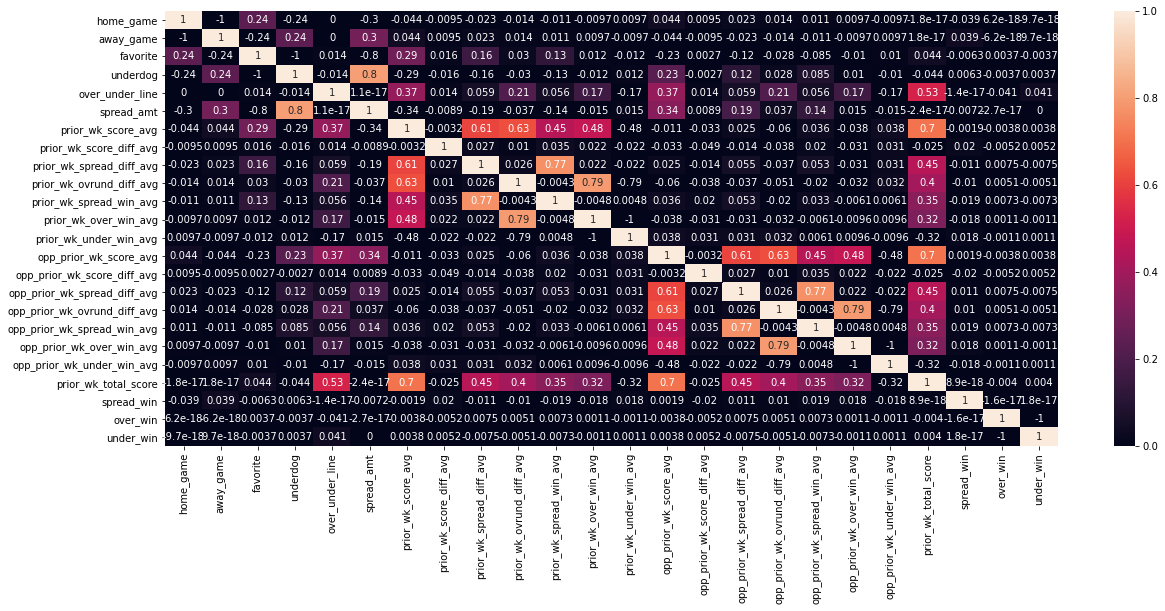

In [38]:
feature_cols = team_stats[['home_game',
                         'away_game',
                         'favorite',
                         'underdog',
                         'over_under_line',
                         'spread_amt',
                         'prior_wk_score_avg', 
                         'prior_wk_score_diff_avg', 
                         'prior_wk_spread_diff_avg', 
                         'prior_wk_ovrund_diff_avg', 
                         'prior_wk_spread_win_avg', 
                         'prior_wk_over_win_avg', 
                         'prior_wk_under_win_avg',
                         'opp_prior_wk_score_avg', 
                         'opp_prior_wk_score_diff_avg', 
                         'opp_prior_wk_spread_diff_avg', 
                         'opp_prior_wk_ovrund_diff_avg', 
                         'opp_prior_wk_spread_win_avg', 
                         'opp_prior_wk_over_win_avg', 
                         'opp_prior_wk_under_win_avg',
                         'prior_wk_total_score',
                         'spread_win',                         
                         'over_win',
                         'under_win']]

plt.subplots(figsize=(20,8))
sns.heatmap(feature_cols.corr(), annot=True, vmin=0, vmax=1);

In [25]:
# write to csv files
team_stats.to_csv        (datapath + "nfl_team_stats.csv",  index=False)
nfl_scores_current.to_csv(datapath + "nfl_scores_2020.csv", index=False)

In [26]:
number_of_games = len(team_stats)/2
home_win_pct    = "{:.2f}".format((sum((team_stats.home_game == 1) & (team_stats.spread_win == 1))  / number_of_games) * 100)
away_win_pct    = "{:.2f}".format((sum((team_stats.away_game == 1) & (team_stats.spread_win == 1))  / number_of_games) * 100)
tie_pct         = "{:.2f}".format((sum((team_stats.home_game == 1) & (team_stats.spread_win == .5)) / number_of_games) * 100)
over_win_pct    = "{:.2f}".format((sum((team_stats.home_game == 1) & (team_stats.over_win   == 1)) / number_of_games) * 100)
under_win_pct   = "{:.2f}".format((sum((team_stats.home_game == 1) & (team_stats.under_win  == 1)) / number_of_games) * 100)

In [27]:
print("Number of games: ", number_of_games)
print("Home Win Pct   : ", home_win_pct)
print("Away Win Pct   : ", away_win_pct)
print("Tie Pct        : ", tie_pct)
print("Over Win Pct   : ", over_win_pct)
print("Under Win Pct  : ", under_win_pct)

Number of games:  1041.0
Home Win Pct   :  41.11
Away Win Pct   :  44.76
Tie Pct        :  14.12
Over Win Pct   :  47.55
Under Win Pct  :  51.39


In [44]:
# prepare models

# training data (2015-2018) and testing data (2019)
train = team_stats.loc[team_stats['schedule_season'] <= 2018]
test  = team_stats.loc[team_stats['schedule_season'] >= 2019]
X_train = train[['home_game',
                         'away_game',
                         'favorite',
                         'underdog',
                         'over_under_line',
                         'spread_amt',
                         'prior_wk_score_avg', 
                         'prior_wk_score_diff_avg', 
                         'prior_wk_spread_diff_avg', 
                         'prior_wk_ovrund_diff_avg', 
                         'prior_wk_spread_win_avg', 
                         'prior_wk_over_win_avg', 
                         'prior_wk_under_win_avg',
                         'opp_prior_wk_score_avg', 
                         'opp_prior_wk_score_diff_avg', 
                         'opp_prior_wk_spread_diff_avg', 
                         'opp_prior_wk_ovrund_diff_avg', 
                         'opp_prior_wk_spread_win_avg', 
                         'opp_prior_wk_over_win_avg', 
                         'opp_prior_wk_under_win_avg',
                         'prior_wk_total_score']]
y_train = train['under_win']
X_test  = test[['home_game',
                         'away_game',
                         'favorite',
                         'underdog',
                         'over_under_line',
                         'spread_amt',
                         'prior_wk_score_avg', 
                         'prior_wk_score_diff_avg', 
                         'prior_wk_spread_diff_avg', 
                         'prior_wk_ovrund_diff_avg', 
                         'prior_wk_spread_win_avg', 
                         'prior_wk_over_win_avg', 
                         'prior_wk_under_win_avg',
                         'opp_prior_wk_score_avg', 
                         'opp_prior_wk_score_diff_avg', 
                         'opp_prior_wk_spread_diff_avg', 
                         'opp_prior_wk_ovrund_diff_avg', 
                         'opp_prior_wk_spread_win_avg', 
                         'opp_prior_wk_over_win_avg', 
                         'opp_prior_wk_under_win_avg',
                         'prior_wk_total_score']]
y_test  = test['under_win']

In [45]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [46]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001DC34A340D0>)),
                ('linearregression', LinearRegression())])

In [47]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [48]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.00430057286050356, -0.0097371456876294)

In [49]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.4913819114049185, 0.49658544674507066)

In [50]:
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

In [51]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x000001DC34A340D0>)),
                ('linearregression', LinearRegression())])

In [52]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [53]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.00470392234841388, -0.011629285932893696)

In [54]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.491126694511275, 0.49693501412309793)

In [57]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [58]:
cv_scores = cv_results['test_score']
cv_scores

array([-0.01898491, -0.02483795, -0.014228  , -0.01642044, -0.02487879])

In [59]:
np.mean(cv_scores), np.std(cv_scores)

(-0.01987001948286502, 0.0043424294317268445)

In [60]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-0.03, -0.01])

In [62]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [63]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [64]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [65]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001DC34A340D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21]})

In [66]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [67]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 1}

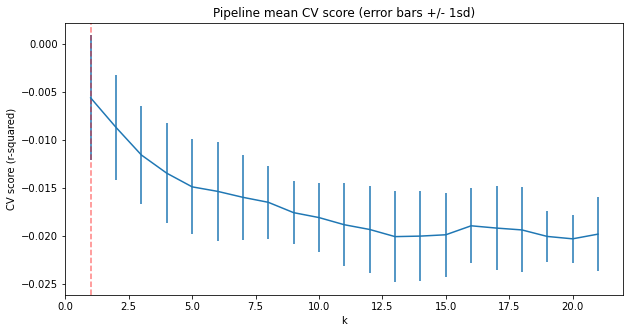

In [68]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [69]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [70]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features)  #.sort(ascending=False)

over_under_line    0.018943
dtype: float64

In [73]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [74]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train,y_train, cv=5)

In [75]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.03641985, -0.01200811,  0.02854204,  0.00395564, -0.03817934])

In [76]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.01082192334006642, 0.025191216557981164)

In [78]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [79]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [80]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [81]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [82]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.00602894, -0.02994862,  0.03678622,  0.02457716, -0.03469941])

In [83]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.0018627175811977593, 0.02855601892919268)

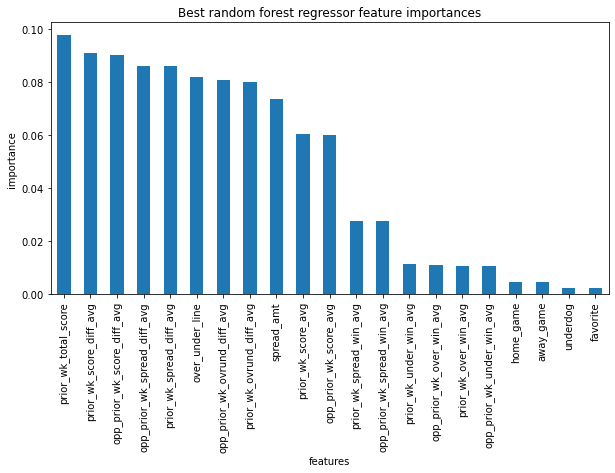

In [84]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [85]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [86]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.4935771515917697, 0.002609338878254493)

In [87]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

0.49537239149765344

In [88]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [89]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(0.48274885634137127, 0.006816242581625948)

In [90]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

0.49313701923076925

In [91]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

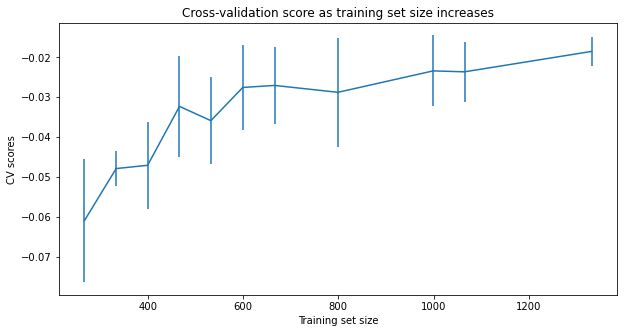

In [92]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');